In [1]:
import numpy as np
import GPy
import seaborn as sns
import math
import matplotlib.pyplot as plt
import edward as ed
import tensorflow as tf
from edward.models import MultivariateNormalFullCovariance, Normal
from scipy.stats import bernoulli
from tqdm import tqdm

## Simulate data using Intensity function

> $$ \lambda_1(s) = 2 \exp\{-s/15\} + \exp\{-((s-25)/10)^2\}$$
> $$ \lambda_2(s) = 5 \sin(s^2) + 6$$

In [2]:
def build_toy_dataset1():
    rate = 2
    measure = 50
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 2*np.exp(-S/15) + np.exp(-((S-25)/10)**2)
    print(N)
    return S, Z, N, rate, measure

def build_toy_dataset2():
    rate = 12
    measure = 5
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 5 * np.sin(S**2) + 6
    print(N)
    return S, Z, N, rate, measure


## Generate and plot data

106


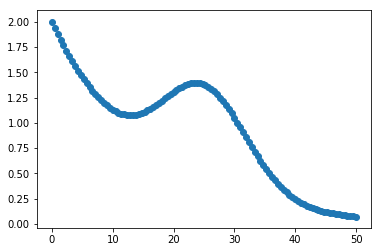

In [3]:
k = GPy.kern.RBF(input_dim=1,lengthscale=1)
S, Z, N, rate, measure = build_toy_dataset1()
plt.scatter(S, Z)
plt.show()

## Thinning events to keep data points consistent with the intensity function

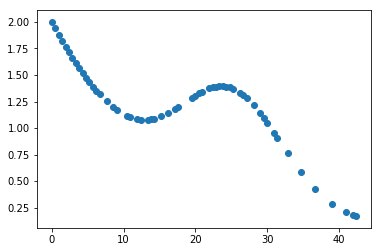

(106, 1)
(57, 1)


In [4]:
R = np.random.uniform(0, 1, N)
V = (Z / rate).flatten()
accept = np.where(R < V)
S_k  = np.take(S, accept, axis=0).reshape(-1,1)
Z_k  = np.take(Z, accept, axis=0).reshape(-1)
plt.scatter(S_k, Z_k)
plt.show()
print(S.shape)
print(S_k.shape)

### Conditional for Gaussian process

In [5]:
def conditional(x_new, x, y, k):

    B = k.K(x_new, x)
    C = k.K(x,x)
    A = k.K(x_new, x_new)
    N = len(C)
    mu = B.dot(np.linalg.inv(C + 1e-6*np.eye(N))).dot(y)
    sigma = A - B.dot(np.linalg.inv(C + 1e-6*np.eye(N)).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

In [17]:
def update(x_K, y_K, x_M, y_M):
   
    bern_p = 0.5
    K = len(x_K)
    
    ### Sampling number of thinned events
    for i in range(10):
        b = bernoulli.rvs(bern_p, size=1)     # Sample from a bernoulli
        M = len(x_M)
        if b==1:
            x_new = np.random.uniform(low=0.0, high = measure, size=(1,1))   # Sample uniformly from the region
            
            mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,x_M), axis=0), np.concatenate((y_K, y_M), axis=0), k)
            y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
            
            ## Calculate insertion ratio
            ratio = np.log(rate * measure)
            ratio -= np.log(M + 1)
            ratio -= np.log(1 + np.exp(y_new))
            a = np.random.uniform(0, 1)
            
            if np.log(a) < ratio:
                x_M = np.concatenate((x_M, x_new), axis=0)
                y_M = np.concatenate((y_M, np.expand_dims(y_new, axis=1)))
        
        
        elif M>0:
            c = np.random.choice(M, 1)[0]    # Uniformly choose an event to delete
            
            ## Calculate deletion ratio
            ratio = np.log(M)
            ratio += np.log(1 + np.exp(y_M[c]))
            ratio -= np.log(rate * measure)
            a = np.random.uniform(0, 1)
            
            if np.log(a) < ratio:
                x_M = np.delete(x_M, c, 0)
                y_M = np.delete(y_M, c)


    ## Sampling the location of thinned events

    for i in range(len(x_M)):   # Use enumerate

        x_new = np.random.uniform(low=0.0, high=measure, size=(1,1))    # Sample a new data point
        mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,x_M), axis=0), np.concatenate((y_K, y_M), axis=0), k)
        y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
        
        # Calculate the acceptance ratio
        ratio = np.log(1 + np.exp(y_M[i]))
        ratio -= np.log(1 + np.exp(y_new))

        a = np.random.uniform(0, 1)
        if np.log(a) < ratio:
            x_M[i] = x_new
            y_M[i] = y_new
            
    
    S = np.concatenate((x_K, x_M), axis=0)
    G = np.concatenate((y_K, y_M), axis=0)
    N = S.shape[0]       # Number of data points K+M
    D = S.shape[1]       # Dimension of the space
    M = len(x_M)
    C = k.K(S,S).astype(np.float32)
    
    ## Learn function values via gradient optimization
    X = tf.constant(C)
    F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)
    prior_loss = 0.5 * tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
    prior_loss = tf.squeeze(prior_loss)
    likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
    likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
    loss = prior_loss + likelihood_loss
    train_op = tf.train.AdadeltaOptimizer(0.1, 0.95, 1e-5).minimize(loss)
    init_OP = tf.global_variables_initializer()
    max_it = 50
    with tf.Session() as sess:
        sess.run(init_OP)
        for i in range(max_it):
            err, _ = sess.run([loss, train_op])
        val = sess.run(F)
    return x_K, y_K, x_M, y_M, val, err

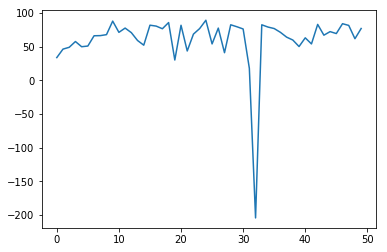

In [15]:
n_iter = 50
x_K, y_K = S_k, Z_k
x_M, y_M = np.empty((0,1)), np.empty((0))
errors = []     # List to maintain loss value at each iteration
for n in range(n_iter):
    
    x_K, y_K, x_M, y_M, val, err = update(x_K, y_K, x_M, y_M)
    errors.append(err)

S = np.concatenate((x_K,x_M), axis=0)
plt.plot(np.arange(n_iter), errors)
#plt.scatter(S, rate / (1 + np.exp(-val)))
plt.show()

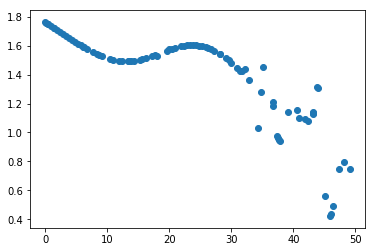

In [16]:
plt.scatter(S, rate / (1 + np.exp(-val)))
plt.show()

# End of Relevant Code


# Junk Code below this cell. Please do not read.

(49, 1) (79,)


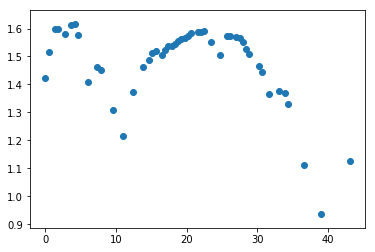

[[  1.00000000e+000   9.00135475e-001   3.87945663e-001 ...,
    7.11633408e-010   5.06444022e-092   6.26233880e-289]
 [  9.00135475e-001   1.00000000e+000   6.56495134e-001 ...,
    1.25774148e-008   5.54218989e-088   1.02038186e-281]
 [  3.87945663e-001   6.56495134e-001   1.00000000e+000 ...,
    2.08981943e-006   3.53043788e-080   1.44099453e-267]
 ..., 
 [  7.11633408e-010   1.25774148e-008   2.08981943e-006 ...,
    1.00000000e+000   2.26269832e-043   2.19255894e-195]
 [  5.06444022e-092   5.54218989e-088   3.53043788e-080 ...,
    2.26269832e-043   1.00000000e+000   8.29094444e-056]
 [  6.26233880e-289   1.02038186e-281   1.44099453e-267 ...,
    2.19255894e-195   8.29094444e-056   1.00000000e+000]]
[[  1.00000000e+00   9.00135458e-01   3.87945652e-01 ...,   7.11633419e-10
    0.00000000e+00   0.00000000e+00]
 [  9.00135458e-01   1.00000000e+00   6.56495154e-01 ...,   1.25774147e-08
    0.00000000e+00   0.00000000e+00]
 [  3.87945652e-01   6.56495154e-01   1.00000000e+00 ...,   

In [18]:
S = np.concatenate((x_K,x_M), axis=0)
print(x_K.shape, val.shape)
plt.scatter(x_K, rate / (1 + np.exp(-val[:K])))
plt.show()
print(k.K(S, S))
print(C)
print(rate, measure)

In [116]:
print(len(x_K), len(x_M))

43 109


152
43 109


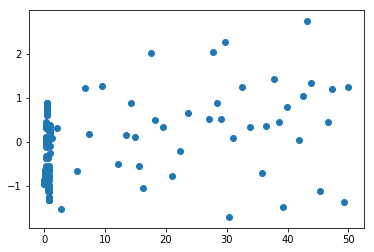

In [117]:

K = len(x_K)
M = len(x_M)
print(N)
print(K,M)
plt.scatter(S, G)
plt.show()

In [118]:
X = tf.constant(C)
F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)

prior_loss = 0.5*tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
prior_loss = tf.squeeze(prior_loss)

In [152]:
#tf.ones(shape=[K])
#tf.slice(F, [0], [K])
likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
loss = prior_loss + likelihood_loss
train_op = tf.train.AdadeltaOptimizer(0.01, 0.95, 1e-5).minimize(loss)
#train_op = tf.train.GradientDescentOptimizer(1e-7).minimize(loss)
init_OP = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init_OP)
    l = sess.run(loss)
    print(l)
    for i in range(100):
        #print(sess.run(tf.gradients(loss, F)))
        sess.run(train_op)
        l = sess.run(loss)
        print(l)
        
    val = sess.run(F)
    
import tqdm

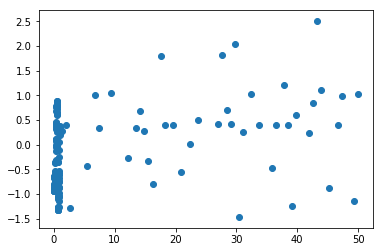

In [121]:
plt.scatter(S, val)
plt.show()